# Profundizando en Tensorflow

Aqui vamos a estudiar las herramientas que se usaran para construir modelos de deep learning, esto es [Tensorflow](https://www.tensorflow.org/).

En primer lugar, instalar Tensorflow con pip:
* `pip install tensorflow` , solo TF en cpu tanto en Linux comom en Mac OS
* Si quieres soporte para GPU mira esta pagina: [instalacion TF](https://www.tensorflow.org/install/)

# Visualizacion

Ejecutando este notebook localmente, el acceso a TensorBoard seria en http://127.0.0.1:7007/

In [1]:
! killall tensorboard
import os
os.system('tensorboard --logdir=/tmp/tboard --port=7007 &');

No matching processes belonging to you were found


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
from keras_utils import reset_tf_session
s = reset_tf_session()

Using TensorFlow backend.


# Empezando
Para empezar vamos a implementar una funcion que calcule la suma de los cuadrados de los numeros de 0 a N-1.

In [3]:
import numpy as np
def suma_cuad(N):
    return np.sum(np.arange(N)**2)

In [4]:
%%time
suma_cuad(10**5)

CPU times: user 668 µs, sys: 518 µs, total: 1.19 ms
Wall time: 655 µs


333328333350000

# Tensoflow 

Hacemos exactamente lo mismo con Tensorflow

In [5]:
# Un parametro entero
N = tf.placeholder('int64', name='entrada_a_la_funcion')

# Produce el mimso resultado
res = tf.reduce_sum(tf.range(N)**2)

In [6]:
res

<tf.Tensor 'Sum:0' shape=() dtype=int64>

In [7]:
%%time
res.eval({N: 10**5})

CPU times: user 3.43 ms, sys: 1.53 ms, total: 4.96 ms
Wall time: 2.82 ms


333328333350000

In [8]:
escritor = tf.summary.FileWriter('/tmp/tboard', graph=s.graph)

# ¿Como funciona?
1. Se definen unos marcadores (placeholders) donde se envian las entradas (inputs)
2. Se hace un grafo simbolico (symbolic graph): una receta para transformaciones matematicas de esos marcadores 
3. Se calculan las salidas del grafo con valores para cada marcador
  * `salida.eval({marcador:valor})`
  * `s.run(salida, {marcador:valor})`

Asi que existen dos entidades principales: el marcador (placeholder) y la transformacion matematica
* Ambos pueden ser numeros, vectores, matrices, tensores, etc...
* Ambos pueden ser int32/64, floats, booleanos (uint8)...
* Se pueden definir nuevas transformaciones como operaciones arbitrarias en los marcadores y otras transformaciones
 * `tf.reduce_sum(tf.arange(N)**2)` son 3 transformaciones secuenciales del marcador `N`
 * Hay una version simbolica en Tensorflow para cada funcion de numpy 
   * `a+b, a/b, a**b, ...` se comporta igual que en numpy
   * `np.mean` -> `tf.reduce_mean`
   * `np.arange` -> `tf.range`
   * `np.cumsum` -> `tf.cumsum`
   * Si no encuentras la funcion que necesitas, puedes mirar la [documentacion](https://www.tensorflow.org/api_docs/python).
   
`tf.contrib` tiene muchas caracteristicas de alto nivel, echale un ojo.

In [9]:
with tf.name_scope('Ejemplo_marcadores'):
    # El marcador por defecto (placeholder) puede ser arbitrariamente float32
    # escalar, vector, matrix, etc...
    entrada_arbitraria = tf.placeholder('float32')

    # Vector de entrada de longitud arbitraria
    vector_entrada = tf.placeholder('float32', shape=(None,))

    # Vector de entrada que tienec 10 elementos de tipo entero
    vector_fijo = tf.placeholder('int32', shape=(10,))

    # Matriz con numero de filas arbitrario y 15 columnas
    # (e.g. una muestra de tu tabla de datos)
    matriz_entrada = tf.placeholder('float32', shape=(None, 15))
    
    # Generalmente se usa None cuando no se necesita especificar la dimension
    entrada1 = tf.placeholder('float64', shape=(None, 100, None))
    entrada2 = tf.placeholder('int32', shape=(None, None, 3, 224, 224))

    # Multiplicacion elemento a elemento
    vector_doble = vector_entrada*2

    # Coseno
    coseno = tf.cos(vector_entrada)

    # Diferencia entre el vector al cuadrado y el propio vector mas uno 
    cuadrado_vector = vector_entrada**2 - vector_entrada + 1

In [10]:
mi_vector =  tf.placeholder('float32', shape=(None,), name="VECTOR_1")
mi_vector2 = tf.placeholder('float32', shape=(None,))
mi_transformacion = mi_vector * mi_vector2 / (tf.sin(mi_vector) + 1)

In [11]:
print(mi_transformacion)

Tensor("truediv:0", shape=(?,), dtype=float32)


In [12]:
dummy = np.arange(5).astype('float32')
print(dummy)
mi_transformacion.eval({mi_vector:dummy, mi_vector2:dummy[::-1]})

[0. 1. 2. 3. 4.]


array([0.       , 1.6291324, 2.0950115, 2.6289961, 0.       ],
      dtype=float32)

In [13]:
escritor.add_graph(mi_transformacion.graph)
escritor.flush()

TensorBoard permite escribir escalares, imagenes, audio, histogramas. Puedes leer mas sobre tensorboard [aqui](https://www.tensorflow.org/get_started/graph_viz).

# Resumen
* Tensorflow esta basado en la computacion de grafos
* Los grafos constan de marcadores (placeholders) y transformaciones

# Error cuadratico medio

La tarea es implementar el error cuadratico medio en Tensorflow.

In [14]:
y = np.arange(5)
y_pred = np.arange(5)[::-1]

In [15]:
(y - y_pred) ** 2

array([16,  4,  0,  4, 16])

In [16]:
with tf.name_scope('MSE'):
    y_true = tf.placeholder('float32', shape=(None,), name='y_true')
    y_predicho = tf.placeholder('float32', shape=(None,), name='y_predicho')
    mse = tf.reduce_mean((y_true - y_predicho) ** 2)
def c_mse(vector1, vector2):
    return mse.eval({y_true: vector1, y_predicho: vector2})

In [17]:
escritor.add_graph(mse.graph)
escritor.flush()

In [18]:
# Testeo local de la implementacion del MSE
import sklearn.metrics
for n in [1, 5, 10, 10**3]:
    elems = [np.arange(n), np.arange(n, 0, -1), np.zeros(n),
             np.ones(n), np.random.random(n), np.random.randint(100, size=n)]
    for e in elems:
        for e_2 in elems:
            true_mse = np.array(sklearn.metrics.mean_squared_error(e, e_2))
            mi_mse = c_mse(e, e_2)
            if not np.allclose(true_mse, mi_mse):
                print('mse({},{})'.format(e, e_2))
                print('deberia ser: {}, pero la funcion devuelve {}'.format(true_mse, mi_mse))
                raise ValueError('Resultado incorrecto')

# Variables

Las entradas y las transformaciones no tienen valores fuera de la funcion. Esto no es demasiado comodo si quieres que el modelo tenga parametros (e.g. pesos de la red) que cambien en el tiempo.

Tensorflow soluciona esto con objetos `tf.Variable`.
* Se puede asignar a la variable un valor en cualquier momento en el grafo
* A diferencia de los marcadores, no hay necesidad de pasar explicitamente valores a las variables cuando se ejecuta `s.run(...)`
* Se pueden usar variables de la misma manera que se usan transformaciones 
 

In [19]:
# Creando una variable compartida
comp_vector_1 = tf.Variable(initial_value=np.ones(5), name='ejemplo_variable')

In [20]:
# Inicializar variables con valores iniciales
s.run(tf.global_variables_initializer())

# Evaluando la variable compartida 
print('Valor inicial', s.run(comp_vector_1))


Valor inicial [1. 1. 1. 1. 1.]


In [21]:
# Configurando nuevo valor
s.run(comp_vector_1.assign(np.arange(5)))

# Obteniendo nuevo valor
print('Nuevo valor', s.run(comp_vector_1))

Nuevo valor [0. 1. 2. 3. 4.]


# tf.gradients - por que importan los grafos
* Tensorflow can computar las derivadas y los gradientes automaticamente usando la computacion de grafos
* Puede manejar derivadas de matrices
* Los gradientes se calculan como un producto de derivadas a traves de la regla de la cadena:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

Por lo tanto se puede derivar cualquier grafo si se sabe derivar de manera elemental.

In [22]:
escalar = tf.placeholder('float32')

escalar_cuadrado = escalar**2

# Derivada del cuadrado del escalar por el propio escalar
derivada = tf.gradients(escalar_cuadrado, [escalar, ])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
derivada

[<tf.Tensor 'gradients/pow_1_grad/Reshape:0' shape=<unknown> dtype=float32>]

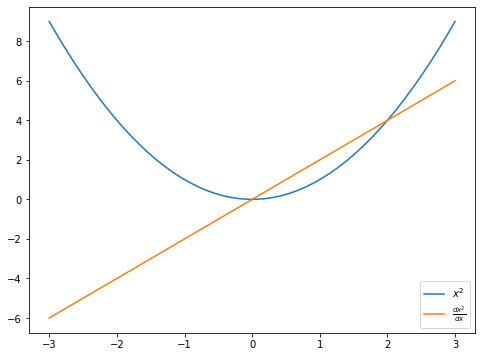

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-3, 3)
x_cuad, x_cuad_der = s.run([escalar_cuadrado, derivada[0]], {escalar:x})

plt.figure(figsize=(8,6))
plt.plot(x, x_cuad, label='$x^2$')
plt.plot(x, x_cuad_der, label=r'$\frac{dx^2}{dx}$')
plt.legend();

# Por que mola

In [25]:
mi_vector = tf.placeholder('float32', [None])

# Calcula el gradiente de la siguiente funcion respecto del escalar y del vector
# !Peligro! Tratar de entender el significado de la siguiente funcion puede resultar en daño cerebral permanente

funcion_psycho = tf.reduce_mean((mi_vector+escalar)**(1+tf.nn.moments(mi_vector,[0])[1]) + 
                                 1./ tf.atan(escalar))/(escalar**2 + 1) + 0.01*tf.sin(
                                 2*escalar**1.5)*(tf.reduce_sum(mi_vector)* escalar**2
                                 )*tf.exp((escalar-4)**2)/(
                                 1+tf.exp((escalar-4)**2))*(1.-(tf.exp(-(escalar-4)**2)
                                 )/(1+tf.exp(-(escalar-4)**2)))**2

deriv_escalar = tf.gradients(funcion_psycho, escalar)
derir_vector = tf.gradients(funcion_psycho, mi_vector)

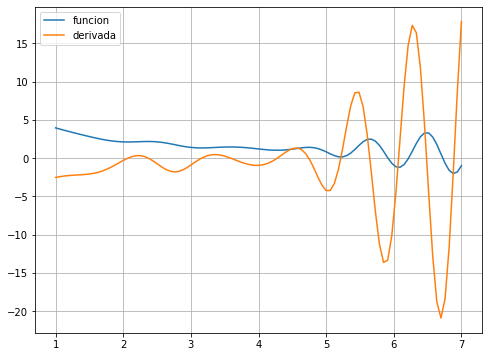

In [26]:
# Ploteando la derivada
espacio_escalar = np.linspace(1, 7, 100)

y = [s.run(funcion_psycho, {escalar: x, mi_vector:[1, 2, 3]}) for x in espacio_escalar]

plt.figure(figsize=(8,6))
plt.plot(espacio_escalar, y, label='funcion')

y_deriv_escalar = [s.run(deriv_escalar, {escalar: x, mi_vector:[1, 2, 3]}) for x in espacio_escalar]

plt.plot(espacio_escalar, y_deriv_escalar, label='derivada')
plt.grid()
plt.legend();

# Casi hecho - optimizadores

Mientras que se puede realizar el gradiente descente a mano con los gradientes de arriba, Tensorflow tambien tiene algunos metodos de optimizacion para implementar (momentum y rmsprop).

In [27]:
y_supuesto = tf.Variable(np.zeros(2, dtype='float32'))
y_true = tf.range(1, 3, dtype='float32')
perdida = tf.reduce_mean((y_supuesto - y_true + tf.random_normal([2]))**2) 
#perdida = tf.reduce_mean((y_supuesto - y_true)**2) 
optimizador = tf.train.MomentumOptimizer(0.01, 0.5).minimize(perdida, var_list=y_supuesto)

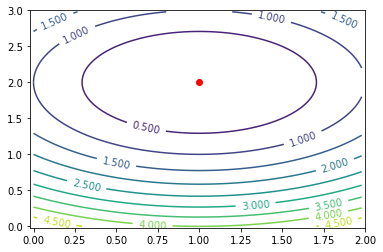

In [28]:
from matplotlib import animation, rc
import matplotlib_utils
from IPython.display import HTML, display_html

fig, ax = plt.subplots()
y_true_val = s.run(y_true)
nivel_x = np.arange(0, 2, 0.02)
nivel_y = np.arange(0, 3, 0.02)
X, Y = np.meshgrid(nivel_x, nivel_y)
Z = (X - y_true_val[0])**2 + (Y - y_true_val[1])**2
ax.set_xlim(-0.02, 2)
ax.set_ylim(-0.02, 3)
s.run(tf.global_variables_initializer())
ax.scatter(*s.run(y_true), c='red')
contorno = ax.contour(X, Y, Z, 10)
ax.clabel(contorno, inline=1, fontsize=10)
linea, = ax.plot([], [], lw=2)

def inicio():
    linea.set_data([], [])
    return (linea,)

supuestos = [s.run(y_supuesto)]

def animacion(i):
    s.run(optimizador)
    supuestos.append(s.run(y_supuesto))
    linea.set_data(*zip(*supuestos))
    return (linea,)

anim = animation.FuncAnimation(fig, animacion, init_func=inicio , frames=400, interval=20, blit=True)

In [29]:
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
try:
    display_html(HTML(anim.to_html5_video()))
except (RuntimeError, KeyError):
    anim.save(None, writer=matplotlib_utils.SimpleMovieWriter(0.001))

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorj/AAR%2B0J8A/iZ431n4Z/Dj44eD/EHiTw5JJH4h8P6J4ltbu%2B0t0kMTrcQRSNJAVkBQh1GGG088VZsPjb8GNV%2BKV78DdL%2BLvhi58babZLeaj4Pt9ftn1S1tiEImktA/nJGRJHh2UA7155FAHT0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHyM/iK78Sf8ABRXRvjLpWnfFnWdA8OeFNe0jVrLxH8LL/T9N8KS3FxpcStpco06CXVDdy2xaQ%2BZfIiIZkktolxJy/wANfAHxBg/ae8IfDi4%2BFHii313wp%2B0r428deJvGNx4Zuo9Ku/Dmo6XrcVj5epNGLe6kI1LSbU2qSNKn2BmZFWBCfuGigDxD9tfx3%2B078LPC2i%2BNvgH4%2B8B6bbXPi/w54f1Cx8X%2BA73VZHfVddsdL%2B0Ry22q2YjESXhk8so%2B8xgb0ByLP/CD/wDBQv8A6Og%2BDP8A4YfVv/moo/bw/wCSIaH/ANlm%2BHH/AKmuiV7NQB4z/wAIP/wUL/6Og%2BDP/hh9W/8AmoqtrPh/9vPw7pNzr/iD9rX4IWNjZQPPeXt58DtUihgiUFmd3bxSFVQASSSAAK7j4d/HDTPH/wAQPEnw2uPBut6Dqfh4xyJHrkUMf9pWjySxLeW4jlctCZYJUywVuFJUB1J8N8X%2BGfjB4f0nxN8PvjTo19q%2Bm/EHxPL4btPGMvjF57hUvHkNjJDpaQrDbQQsyROY2EpCmZgVUmuqlhXOfLN2206tPtrba7/pnNUxCjDmir7/ACa7/PQyvEfxw/bt1ODwynwE/aT%2BAvjm58UXl7FZLH8JtUs4QLSHzp18w%2BJJP323aFiKgtu3EqgZh2/wr1D9u/4t%2BArDx94f/aa%2BEEMF6JFltbr4Cass1rPFI0U0Eg/4Snh45Y5I2HqhrL8NfB74s/GD4kXPjDxV4N1PwDq%2Bl2Ol3L66zW0sNx4itXkR7i3jilPnW0lrLJE5YRlkuGT7y5T2/wCDPwzuPhV4Ok0LUvEQ1fUb3VLzU9W1JLIWyXF1cztNIUiDN5aAttVdzEBRlmOSdMTTw1OmoxfvffvfqtNrbWflrpFCeIqTvJe793bvr3/pa%2BD%2BCU/4LGeIfidq%2BjeLPFnwF8P%2BELCeaHTdfn%2BHGqXN9qe1sRzJZxeISsUbgE/vJw4yPk6477/hB/8AgoX/ANHQfBn/AMMPq3/zUV7NRXJOSm7pJel/1bOqEXFWbv6/8Cx4z/wg/wDwUL/6Og%2BDP/hh9W/%2Baij/AIQf/goX/wBHQfBn/wAMPq3/AM1FezVi%2BPfiT8O/hX4fk8V/E7x5o3h3S4v9ZqOuanFaQL35eVlX9amMZSdoq7K2PM/%2BEH/4KF/9HQfBn/ww%2Brf/ADUUf8IP/wAFC/8Ao6D4M/8Ahh9W/wDmormpv%2BClvwf8YTvp37M3w08f/F%2B5VzH9o8C%2BFZf7NSTOAH1G7MFqF/2lkb6HFNHij/gqB8VedA%2BF3ww%2BElhJ8rS%2BKNauPEmqRj%2B8IbMQWyt7GZxn1612f2fiI/xbQ/xNJ/drL/yUjnj01On/AOEH/wCChf8A0dB8Gf8Aww%2Brf/NRWZ4rT9tjwJpp1nxx%2B2d8BtGs1%2B9d6r8FtSt4h/wKTxUB%2BtZo/Yf%2BMnjv97%2B0D%2B3/APFHXM/e07wU9r4WsmXupFlGbgj6zk4PJNanhX/gmT%2Bwp4W1Ia7cfs56L4g1HgvqXjSSbXbh267i%2BoSTHOeeMY7Yo9lgYfHVcv8ADH9ZNfkF5vZHjHij/goFqvhbUTo5/wCCnf7PGsXoyPsXhP4Ea5rcxPoE0/xLMSe2MVm/8Nt/t7a9/wAkv8P6l4qR/wDUXdr%2ByBrWnW0voRLqXi22G335%2Blfb3hfwb4Q8EacNH8F%2BFdN0i0X7trpdjHbxj/gMYArSo9rgI/DTb9ZW/CMf1C0%2B58Ix/F//AIL7684bwr%2Bz38IrSFz8k3i7w%2B1kcepS18TXbD6EZruvhlZf8Fzdd8Q2v/C2PGP7LHh3Rn3fbJNJ8HeItSvY/kO3bE2pwRt820H96MAk8kAH60oqJ4ilKNo0or/wJv8AGX6DUX3PGf8AhB/%2BChf/AEdB8Gf/AAw%2Brf8AzUUf8IP/AMFC/wDo6D4M/wDhh9W/%2BaivZqK5Sjxn/hB/%2BChf/R0HwZ/8MPq3/wA1FH/CD/8ABQv/AKOg%2BDP/AIYfVv8A5qK9mooA8Z/4Qf8A4KF/9HQfBn/ww%2Brf/NRR/wAIP/wUL/6Og%2BDP/hh9W/8Amor2aigDxn/hB/8AgoX/ANHQfBn/AMMPq3/zUUf8IP8A8FC%2B37UHwZ/8MPq3/wA1FezUUAfFniG%2B/wCDg/Qd0mmWv7JmuoPupYaT4igkI9xPfKoP/AjWH/wvz/guR4b/AH3xF/Z08Ei3X78/g3wBHq5/4DG/i%2B3kP/fIr7vorsjiaNrSoxf/AIEvyk/yJ5X3Plv4DfEL/goT8ddN1G%2Bfx34X8Fy6bOkUtl48/Zk1fT5ZiwJ3QkeLHSZRjBZGIBIFafxE13/goF4B8U%2BDfB0f7QPwb1C98ZeIX0y2A%2BCuqwi1jjsrm7muWz4lbzAqW%2B3Z8uWkX5hX0jXnfjv9nHQvG/xe0P42p8Q/Fml6z4fgmisLew1dXsCssTRyFrS4SSEMVPLoqv8AKPm65inLDuu5NWjZ2WstbO3Z7636A%2Bax4P8AHr4y/wDBQ34Najeabovxc%2BEXiJ9C8OSeI/Fjw/BjUrZdK0lC4afL%2BJz50p8qYrCoBYRNyOM6ln8Z/wBrG/8AidB8KLf9q/4VHULi7FlFen9m/XRYm/8Asou/sP2n/hJvLFz9nPm%2BVu3bQ3dSB3Xxb/ZX8bfEPxPe3GlfFG0tdJ8U6DYaR46S60YveXdvazSSbraRJEjhMyyNE6tGyhWLLhs54LxB%2Bz7%2B0dDFrvhrw34asraz0HWPEXifw3rUerqZNY1CeJ10y3EYG%2BExrIUlkfglFKAhyE66dHA1KSTkk7d7b979n0XTV%2BUtzTOm8Fa7%2B158SLnUbL4e/tyfs%2B67NpFz9n1aHSPg5qNw9lLz8kqx%2BKiY2ODgNjOOK3/%2BEH/4KF/9HQfBn/ww%2Brf/ADUVifsj%2BELs%2BLYfFWheCtb8O%2BGfD3w60jwlplt4g0aXTrq9ktgZXcwTKsipEZDGrMAGZ5SpZSGPZ/Eb9sz9l/4P/FCD4O/Fr4y6T4X166tI7m0i8Qs9nbTo5YKEupVWBnypygk3DIyBuGearhZe3dOinKyvtd%

# Regresion logistica
La tarea es implementar la regresion logistica

Plan:
* Usar una variable compartida para los pesos
* Usar una matriz marcador para `X`
 
Se entrenara en el dataset MNIST de dos clases
* notar que el objetivo `y` es `{0,1}` y no `{-1,1}` 

In [30]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X, y = mnist.data, mnist.target

print('y [shape - {}]:'.format(str(y.shape)), y[:10])
print('X [shape - {}]:'.format(str(X.shape)))

y [shape - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [shape - (360, 64)]:


X:
 [[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0.]
 [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.]
 [ 0.  0.  1.  9. 15. 11.  0.  0.  0.  0.]]
y:
 [0 1 0 1 0 1 0 0 1 1]


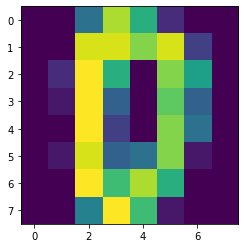

In [31]:
print('X:\n',X[:3,:10])
print('y:\n',y[:10])
plt.imshow(X[7].reshape([8,8]));

Ahora es tu turno.
Solo un recordatorio de matematicas:

$$
P(y=1|X) = \sigma(X \cdot W + b)
$$
$$
\text{perdida} = -\log\left(P\left(y_\text{predicho} = 1\right)\right)\cdot y_\text{true} - \log\left(1 - P\left(y_\text{predicho} = 1\right)\right)\cdot\left(1 - y_\text{true}\right)
$$

$\sigma(x)$ esta en `tf.nn.sigmoid` y la multiplicacion matricial en `tf.matmul`

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [33]:
# Parametros del modelo - pesos y sesgos
# pesos = tf.Variable(...) la dimension debe ser (X.shape[1], 1)
# sesgo = tf.Variable(...)

pesos = tf.Variable(np.zeros((X.shape[1], 1), dtype='float32'))
sesgo = tf.Variable(np.zeros(None), dtype='float32')

In [34]:
# Marcadores (placeholders) para los datos de entrada
# input_X = tf.placeholder(...)
# input_y = tf.placeholder(...)

input_X = tf.placeholder('float32', shape=(None, X.shape[1]), name="input_X")
input_y = tf.placeholder('float32', shape=(None,), name="input_y")

In [35]:
# Codigo del modelo

# Calcular un vector de predicciones, cuya dimension deberia ser [input_X.shape[0],]
# Esto es 1D, si hay dimensiones extra,se puede redimensionar con with tf.squeeze.
# No olvidar la sigmoide.
# y_pred = <probabilidades predichas para input_X>

y_pred = tf.squeeze(tf.sigmoid(input_X @ pesos + sesgo))

# Perdida. Debe ser un escalar, un numero - perdida media sobre todos los objetos
# tf.reduce_mean aqui es tu amigo
# perdida = <perdida logistica (escalar, media sobre la muestra)>
perdida = tf.reduce_mean(-tf.log(y_pred) * input_y - tf.log(1 - y_pred) * (1 - input_y))

# See above for an example. tf.train.*Optimizer
# optimizador = <optimizador que minimiza la perdida>
optimizador = tf.train.MomentumOptimizer(0.01, 0.5).minimize(perdida, var_list=[pesos, sesgo])

Un test ayuda con el debugging

In [36]:
pesos_validacion = 1e-3 * np.fromiter(map(lambda x:
                                      s.run(funcion_psycho, {escalar:x, mi_vector:[1, 0.1, 2]}),
                                      0.15 * np.arange(1, X.shape[1] + 1)),
                                      count=X.shape[1], dtype=np.float32)[:, np.newaxis]

# Compute predictions for given weights and bias
pred_validacion = s.run(y_pred, {input_X: X, pesos: pesos_validacion, sesgo: 1e-1})

#pred_validacion = pred_validacion.flatten()

# Cargar los valores de referencia para las predicciones
validacion_true_val = np.loadtxt('predicciones_de_validacion.txt')

assert pred_validacion.shape == (X.shape[0],),\
       'Las predicciones deben ser 1D con longitud igual al numero de ejemplos en input_X' 

assert np.allclose(validacion_true_val, pred_validacion)
perdida_validacion = s.run(perdida,{input_X: X[:100], input_y: y[-100:],pesos: pesos_validacion+1.21e-3,sesgo: -1e-1})

assert np.allclose(perdida_validacion, 0.728689)

In [37]:
from sklearn.metrics import roc_auc_score
s.run(tf.global_variables_initializer())

for i in range(5):
    s.run(optimizador, {input_X: X_train, input_y: y_train})
    perdida_i = s.run(perdida, {input_X: X_train, input_y: y_train})
    print('perdida en la iteracion {}:{:0.4f}'.format(i, perdida_i))
    print('auc entrenamiento:', roc_auc_score(y_train, s.run(y_pred, {input_X:X_train})))
    print('auc test:', roc_auc_score(y_test, s.run(y_pred, {input_X:X_test})))
    print ()

perdida en la iteracion 0:0.1252
auc entrenamiento: 0.9999451032059727
auc test: 1.0

perdida en la iteracion 1:0.0450
auc entrenamiento: 1.0
auc test: 1.0

perdida en la iteracion 2:0.0269
auc entrenamiento: 1.0
auc test: 1.0

perdida en la iteracion 3:0.0200
auc entrenamiento: 1.0
auc test: 1.0

perdida en la iteracion 4:0.0169
auc entrenamiento: 1.0
auc test: 1.0



In [38]:
# era submision aqui

In [39]:
pesos_test = 1e-3 * np.fromiter(map(lambda x: s.run(funcion_psycho, {escalar:x, mi_vector:[1, 2, 3]}),
                                              0.1 * np.arange(1, X.shape[1] + 1)),
                                              count=X.shape[1], dtype=np.float32)[:, np.newaxis]

Primero, la prediccion de test y la perdida. Esta parte no requiere entrenar el modelo.

In [40]:
test_pred = s.run(y_pred, {input_X: X, pesos: pesos_test, sesgo: 1e-1})

In [41]:
assert test_pred.shape == (X.shape[0],),\
       'Las predicciones deben ser 1D con longitud igual al numero de ejemplos en X_test' 

In [42]:
perdida_test = s.run(perdida, {input_X: X[:100], input_y: y[-100:], pesos: pesos_test+1.21e-3, sesgo: -1e-1})
# Si, que los indices X/y no concuerden es intencional